In [1]:
import pymongo as pm
import metaknowledge as mk
import os
import pyprind
import pickle
import spacy
import numpy as np
import pandas as pd

from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import coo_matrix
from scipy.spatial.distance import cosine


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Various plots based on this data.


Interactive visualizations are up on Tableau:

[Topic Explorer](https://public.tableau.com/profile/michael.burnam.fink#!/vizhome/MBF_Fletcher_Journal_Topic_Explorer/Dashboard2)

[Paper Explorer](https://public.tableau.com/profile/michael.burnam.fink#!/vizhome/MBF_Fletcher_Paper_Explorer/Dashboard1)

In [2]:
client = pm.MongoClient()
local = client.local
local.list_collection_names()
fletcher = local.get_collection('fletcher')

In [8]:
progbar = pyprind.ProgBar(fletcher.count())

points = []

for a in fletcher.find():
    try:
        title = a['TI']
        journal = a['SO']
        subject = a['WC']
        pubyear = a['PY']
        cites = a['Z9']
        lda_topics = a['lda_doc']
        SDI = a['SDI']
        LDA1 = a['LDA40x3Plain']
        LDA2 =a['LDA40x3Trim01']
        JSD = a['JSD40x3Trim01']
        tJSD = a ['tJSD40x3Trim01']
        point = (title, journal, subject, pubyear, cites, SDI, LDA1, LDA2, JSD, tJSD, lda_topics)
        points.append(point)
    except:
        pass
    progbar.update()

/home/michael/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: count is deprecated. Use estimated_document_count or count_documents instead. Please note that $where must be replaced by $expr, $near must be replaced by $geoWithin with $center, and $nearSphere must be replaced by $geoWithin with $centerSphere
  """Entry point for launching an IPython kernel.
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:19


In [9]:
df = pd.DataFrame(points, columns = ['Title', 'Journal', 'Subject', 'PubYear', 'Cites', 'SDI', 'LDA1', 'LDA2','JSD', 'tJSD', 'lda_topics'])

In [2]:
df= pd.read_csv('11-15 papers.csv', index_col=0)
df.head()

,Title,Journal,Subject,PubYear,Cites,SDI,LDA1,LDA2,JSD,tJSD,...,30,31,32,33,34,35,36,37,38,39
0,Wasting cash - the decline of the British biot...,NATURE BIOTECHNOLOGY,['Biotechnology & Applied Microbiology'],2009,4,0.047731,0.844102,0.574639,0.362703,0.686472,...,0.0,0.0,0.0,0.0,0.0,0.311859,0.0,0.0,0.0,0.0
1,Gene therapy finds its niche,NATURE BIOTECHNOLOGY,['Biotechnology & Applied Microbiology'],2011,178,0.320200,0.891926,0.394995,0.245290,0.682061,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,MicroRNAs accurately identify cancer tissue or...,NATURE BIOTECHNOLOGY,['Biotechnology & Applied Microbiology'],2008,650,0.395740,0.926077,0.359339,0.198571,0.653698,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,Human embryonic stem cell derivation from poor...,NATURE BIOTECHNOLOGY,['Biotechnology & Applied Microbiology'],2008,70,0.530265,0.912569,0.391444,0.190950,0.648818,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,Spatially isotropic four-dimensional imaging w...,NATURE BIOTECHNOLOGY,['Biotechnology & Applied Microbiology'],2013,99,0.472712,0.984293,0.321837,0.173256,0.655563,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [24]:
df=df.dropna()

In [ ]:
df['Journal'] = df.Journal.apply(lambda x :'ANNUAL REVIEW OF ASTRONOMY AND ASTROPHYSICS' if 'ANNUAL REVIEW OF ASTRONOMY AND ASTROPHYSICS' in x else x)
df['Journal'] = df.Journal.apply(lambda x :'ANNUAL REVIEW OF IMMUNOLOGY' 
                                   if 'ANNUAL REVIEW OF IMMUNOLOGY' in x else x)
df['Journal'] = df.Journal.apply(lambda x :'ANNUAL REVIEW OF PATHOLOGY' 
                                   if 'ANNUAL REVIEW OF PATHOLOGY' in x else x)

Novelty score appears to be a beta distribution.  Since dirichlets are higher-dimensional generalizations of the beta distribution, there may be an underlying mathematical link, or it may be a coincidence.

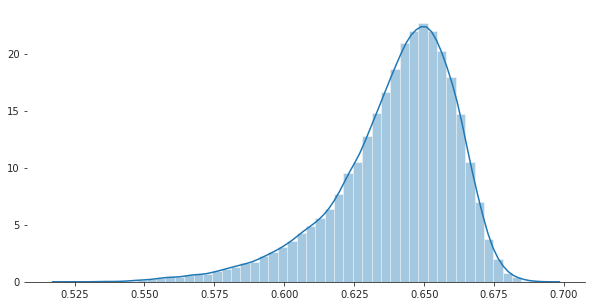

In [60]:
fig = plt.figure(figsize=(10,5))
ax = sns.distplot(df.tJSD)
ax.set_xlabel('')
sns.despine(left=True)
fig.savefig('Novelty.png', dpi=300)

Citation Velocity is a common scientometric measure, indicate how 'hot' a paper or field is.  It's simply citations / years since publication.  Citation velocity follows a log-normal distribution.

In [30]:
df['Velocity']=df.Cites/(2019-df.PubYear)

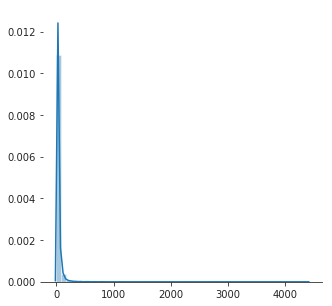

In [64]:
fig = plt.figure(figsize=(5,5))
ax = sns.distplot(df.Velocity)
ax.set_xlabel('')
sns.despine(left=True)
fig.savefig('Velocity.png', dpi=300)

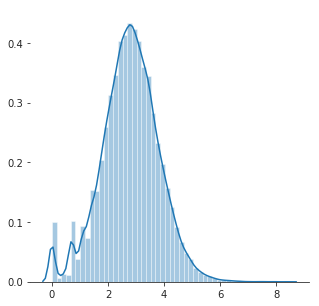

In [63]:
fig = plt.figure(figsize=(5,5))
ax = sns.distplot(df.log_Velocity)
ax.set_xlabel('')
sns.despine(left=True)
fig.savefig('log_Velocity.png', dpi=300)

In [32]:
df.sort_values(by='Velocity', ascending=False).head(10)

,Title,Journal,Subject,PubYear,Cites,SDI,LDA1,LDA2,JSD,tJSD,lda_topics,Velocity
36897,Hallmarks of Cancer: The Next Generation,CELL,"[Biochemistry & Molecular Biology, Cell Biology]",2011,35154,0.268243,0.901453,0.406319,0.253220,0.644628,"[(2, 0.06923989), (9, 0.23716272), (17, 0.3248...",4394.250000
15519,Global Cancer Statistics,CA-A CANCER JOURNAL FOR CLINICIANS,[Oncology],2011,24245,0.284525,0.971441,0.420949,0.246449,0.622126,"[(1, 0.05874187), (7, 0.045052655), (18, 0.122...",3030.625000
15577,"Global Cancer Statistics, 2012",CA-A CANCER JOURNAL FOR CLINICIANS,[Oncology],2015,11188,0.265665,0.965987,0.316642,0.195619,0.633223,"[(16, 0.0058184676), (18, 0.058952227), (24, 0...",2797.000000
15406,"Cancer Statistics, 2016",CA-A CANCER JOURNAL FOR CLINICIANS,[Oncology],2016,8120,0.253302,0.967176,0.072048,0.044070,0.625761,"[(3, 0.022164421), (24, 0.93553126), (36, 0.03...",2706.666667
15443,"Cancer Statistics, 2017",CA-A CANCER JOURNAL FOR CLINICIANS,[Oncology],2017,4732,0.236371,0.966256,0.084451,0.054484,0.619401,"[(24, 0.91312027), (27, 0.030979276), (36, 0.0...",2366.000000
15569,"Cancer Statistics, 2015",CA-A CANCER JOURNAL FOR CLINICIANS,[Oncology],2015,8223,0.256527,0.965774,0.096544,0.054551,0.627643,"[(3, 0.05905281), (24, 0.9379598)]",2055.750000
31738,The rise of graphene,NATURE MATERIALS,"[Chemistry, Physical, Materials Science, Multi...",2007,23198,0.333725,0.966931,0.412154,0.249358,0.651012,"[(2, 0.161506), (4, 0.21450204), (8, 0.1576516...",1933.166667
6514,NIH Image to ImageJ: 25 years of image analysis,NATURE METHODS,[Biochemical Research Methods],2012,12843,0.236480,0.911800,0.272771,0.171300,0.677532,"[(2, 0.15807259), (38, 0.80916876)]",1834.714286
15616,"Cancer Statistics, 2014",CA-A CANCER JOURNAL FOR CLINICIANS,[Oncology],2014,8808,0.264239,0.967122,0.071270,0.044823,0.624700,"[(15, 0.052129846), (24, 0.94510853)]",1761.600000
15587,"Cancer statistics, 2013",CA-A CANCER JOURNAL FOR CLINICIANS,[Oncology],2013,9667,0.262541,0.964267,0.242573,0.139893,0.627087,"[(1, 0.19041938), (24, 0.80702686)]",1611.166667


In [3]:
df['log_Velocity']=np.log10(df.Velocity+1)

/home/michael/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


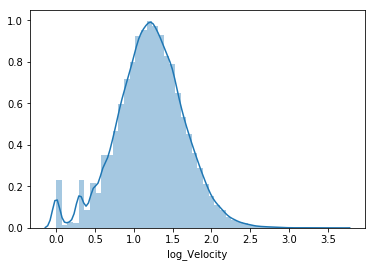

In [4]:
sns.distplot(df.log_Velocity)

We see a slight negative correlation between Novelty and Velocity, which is actually expected for several reasons.

First, there are interactive effects in science.  A high velocity paper will generate a body of literature, shifting the usages of jargon in the field.

Second, many of these papers are widely cited review articles, which are by nature conservative, trending towards the average of the field as a whole.

Third, science that is *too* novel will not be followed on by the community. A paper with wholly new jargon and theories will have trouble finding its niche.

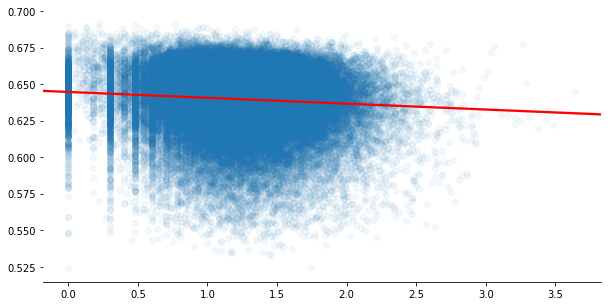

In [5]:
fig = plt.figure(figsize=(10,5))
ax = sns.regplot(df.log_Velocity, df.tJSD, scatter_kws={'alpha':0.05}, line_kws={'color':'red'})
ax.set_xlabel('')
ax.set_ylabel('')
sns.despine(left=True)
fig.savefig('velocity_vs_novelty.png', dpi=300)

Finally. in order to create topic profiles for comparison, we run the following code.

In [82]:
import re
char_list = ['\[', '\]', '\(', '\)']

a = df.lda_topics[0]
b = re.sub('|'.join(char_list), "", a).split(',')
test = dict()
keys = [str(x) for x in range(40)]
for k in keys:
    test[k]=0
for i in range(len(b)//2):
    test[b[i*2].strip()] = float(b[i*2+1])

In [86]:
df.head()

,Title,Journal,Subject,PubYear,Cites,SDI,LDA1,LDA2,JSD,tJSD,lda_topics,Velocity,log_Velocity
0,Wasting cash - the decline of the British biot...,NATURE BIOTECHNOLOGY,[Biotechnology & Applied Microbiology],2009,4,0.047731,0.844102,0.574639,0.362703,0.686472,"[(6, 0.2517191), (13, 0.35933864), (35, 0.3118...",0.400000,0.336472
1,Gene therapy finds its niche,NATURE BIOTECHNOLOGY,[Biotechnology & Applied Microbiology],2011,178,0.320200,0.891926,0.394995,0.245290,0.682061,"[(0, 0.59648186), (29, 0.35074037)]",22.250000,3.146305
2,MicroRNAs accurately identify cancer tissue or...,NATURE BIOTECHNOLOGY,[Biotechnology & Applied Microbiology],2008,650,0.395740,0.926077,0.359339,0.198571,0.653698,"[(17, 0.103994004), (23, 0.70519495), (26, 0.1...",59.090909,4.095859
3,Human embryonic stem cell derivation from poor...,NATURE BIOTECHNOLOGY,[Biotechnology & Applied Microbiology],2008,70,0.530265,0.912569,0.391444,0.190950,0.648818,"[(7, 0.5751126), (12, 0.40661818)]",6.363636,1.996554
4,Spatially isotropic four-dimensional imaging w...,NATURE BIOTECHNOLOGY,[Biotechnology & Applied Microbiology],2013,99,0.472712,0.984293,0.321837,0.173256,0.655563,"[(10, 0.0779133), (22, 0.0142723145), (23, 0.1...",16.500000,2.862201


In [92]:
topic_cats = []

progbar = pyprind.ProgBar(len(df))

for row in df.itertuples():
    a=row[-3]
    b = re.sub('|'.join(char_list), "", a).split(',')
    test = dict()
    keys = [x for x in range(40)]
    for k in keys:
        test[k]=0
    for i in range(len(b)//2):
        test[int(b[i*2].strip())] = float(b[i*2+1])
    topic_cats.append(test)
    progbar.update()

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


In [93]:
df_tc = pd.DataFrame(topic_cats)

df_tc.head()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.251719,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.311859,0.0,0.0,0.0,0.0
1,0.596482,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.575113,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [102]:
df2 = df.join(df_tc)

In [130]:
df2.head()

,Title,Journal,Subject,PubYear,Cites,SDI,LDA1,LDA2,JSD,tJSD,...,30,31,32,33,34,35,36,37,38,39
0,Wasting cash - the decline of the British biot...,NATURE BIOTECHNOLOGY,[Biotechnology & Applied Microbiology],2009,4,0.047731,0.844102,0.574639,0.362703,0.686472,...,0.0,0.0,0.0,0.0,0.0,0.311859,0.0,0.0,0.0,0.0
1,Gene therapy finds its niche,NATURE BIOTECHNOLOGY,[Biotechnology & Applied Microbiology],2011,178,0.320200,0.891926,0.394995,0.245290,0.682061,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,MicroRNAs accurately identify cancer tissue or...,NATURE BIOTECHNOLOGY,[Biotechnology & Applied Microbiology],2008,650,0.395740,0.926077,0.359339,0.198571,0.653698,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,Human embryonic stem cell derivation from poor...,NATURE BIOTECHNOLOGY,[Biotechnology & Applied Microbiology],2008,70,0.530265,0.912569,0.391444,0.190950,0.648818,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,Spatially isotropic four-dimensional imaging w...,NATURE BIOTECHNOLOGY,[Biotechnology & Applied Microbiology],2013,99,0.472712,0.984293,0.321837,0.173256,0.655563,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [127]:
journal_topics = df2.groupby('Journal')[list(range(40))].sum()

In [129]:
journal_topics.to_csv('journal_topics.csv')

A few toy random distributions for my presentation.

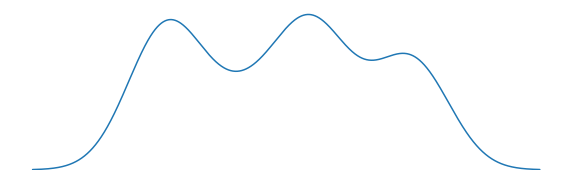

In [45]:
dist_a = list(np.random.random(50)-1.2)+list(np.random.random(20))+list(np.random.random(50)+1.2)+list(np.random.random(40)+2.7)
fig = plt.figure(figsize=(10,3))
ax = sns.kdeplot(dist_a, gridsize=10000)


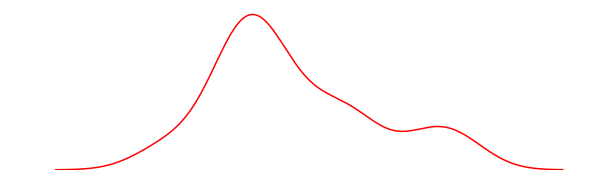

In [47]:
dist_b = list(np.random.random(12)-1.2)+list(np.random.random(70))+list(np.random.random(30)+1.2)+list(np.random.random(20)+2.7)
fig = plt.figure(figsize=(10,3))
ax =sns.kdeplot(dist_b, gridsize=10000, color='red')
ax.set_axis_off()

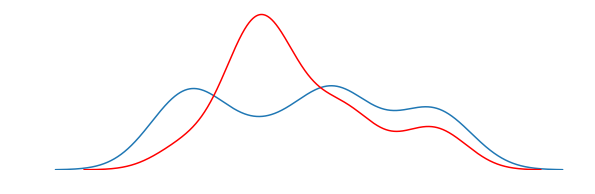

In [48]:
fig = plt.figure(figsize=(10,3))
ax =sns.kdeplot(dist_a, gridsize=10000)
ax =sns.kdeplot(dist_b, gridsize=10000, color='red')
ax.set_axis_off()